In [1]:
from SIFT_gs.FIBSEM_SIFT_gs import *

Open CV version:  4.6.0
SIFT_gs version:  4.0.1


# Set up Local DASK Client and Monitor Window

In [2]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address0 = 'http://localhost:{:d}/status'.format(dport)
print('Use ' + status_update_address0 +' to monitor DASK progress')
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

Using Local Port:    8787
Use http://localhost:8787/status to monitor DASK progress


# Step 0a: Select the Source Directory and Source Files.

In [3]:
fls_dir = os.path.normpath('F:/Hydra')

In [4]:
fls=[]
ftype=1

if ftype == 0:
    fls = sorted(glob.glob(os.path.join(fls_dir,'*.dat')))
    if len(fls) < 1:
        fls = sorted(glob.glob(os.path.join(fls_dir,'*/*.dat')))
if ftype == 1:
    fls = sorted(glob.glob(os.path.join(fls_dir,'*.tif')))
    if len(fls) < 1:
        fls = sorted(glob.glob(os.path.join(fls_dir,'*/*.tif')))

fls = fls[10:]
nfrs = len(fls)
print('Total Number of frames to process: ', nfrs) 

Total Number of frames to process:  207


# Step 0b: Set up Processing Parameters.

In [5]:
# set the results directory
data_dir = os.path.normpath('F:/Hydra/Results')

ftype = 1 # 0 for Shan's .dat files, 1 for tif files

use_DASK = True
DASK_client_retries = 3  # Number of allowed automatic retries if a task fails

threshold_min = 1e-3    # These are used to determine Min and Max data boundaries for I8 conversion
threshold_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.

save_matches = True     # If True, matches will be saved into individual files

kp_max_num = 100000      # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                        # by the strength of the response. Only kp_max_num is kept for further processing.
                        # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = 0     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.025   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 1.6                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7

solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000             # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True          # Save PNG images of the intemediate processing statistics and final registration quality check.

dtp = int16                  # Python data type for saving. Deafult is int16, the other option currently is uint8.

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 11, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 501, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 
subtract_FOVtrend_from_fit = [True, True]  # If True, FOV trends (image shifts performed during imaging) will be subtracted first, so they do not bias the linear trends.

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

flipY = False                 # If True, the dataset will be flipped along Y-direction

zbin_factor =  1             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

eval_metrics = ['NSAD', 'NCC', 'NMI']   # list of metrics used for evaluation of registration (and resolution).
                                        # Options are; 'NSAD', 'NCC', 'NMI', 'FSC'
fnm_types = ['mrc']    #   File type(s) for output data. Options are: ['h5', 'mrc'].
                             # Defauls is ['mrc']. 
                             # 'h5' is BigDataViewer HDF5 format, uses npy2bdv package. Use empty list if do not want to save the data.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic
                        
                        

#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************           

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('\x00')
EightBit = frame0.EightBit
Sample_ID = 'Hydra dataset'

SIFT_kwargs = {
    'ftype' : ftype,
    'data_dir' : data_dir,
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'DASK_client_retries' : DASK_client_retries,
    'threshold_min' : threshold_min, 
    'threshold_max' : threshold_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'kp_max_num' : kp_max_num,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'dtp' : dtp,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'subtract_FOVtrend_from_fit' : subtract_FOVtrend_from_fit,
    'pad_edges' : pad_edges,
    'flipY' : flipY,
    'zbin_factor' : zbin_factor,
    'eval_metrics' : eval_metrics,
    'fnm_types' : fnm_types,
    'int_order' : int_order,
    'suffix' : suffix}

test_dataset = FIBSEM_dataset(fls, fnm_reg = 'Registered_brat0.00.mrc', **SIFT_kwargs)

Registered data will be saved into:  Registered_brat0.00.mrc
Total Number of frames:  207


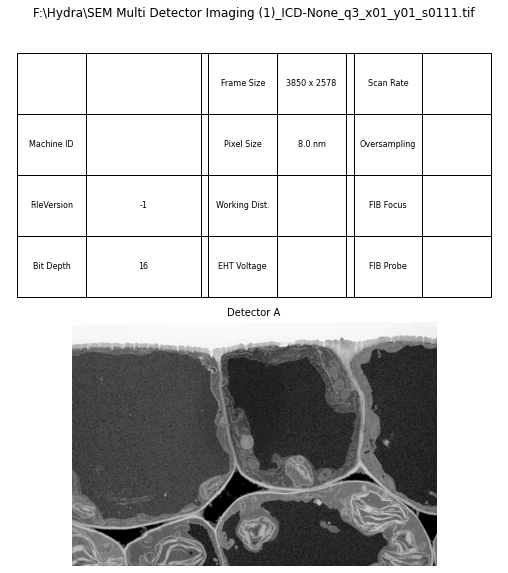

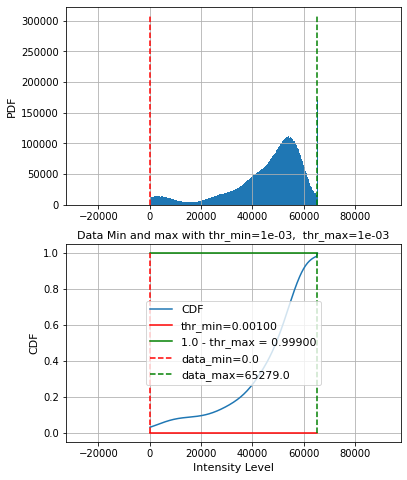

In [6]:
fr_inds = [100]
for fr_ind in fr_inds:
    test_frame = FIBSEM_frame(fls[fr_ind], ftype=ftype)
    snapshot_name = os.path.join(data_dir, os.path.split(fls[fr_ind])[1].replace('.dat', '_snapshot.png'))
    test_frame.save_snapshot(snapshot_name=snapshot_name)
    get_min_max_thresholds(test_frame.RawImageA, disp_res=True)

# Check the settings: Perform SIFT alignements on two frames in the middle of the stack

Hydra dataset
Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 1.00025227e+00 -9.44828732e-04  3.86579031e-01]
 [-3.19426917e-05  1.00020611e+00  9.97514032e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
721 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 702
Wall time: 31.9 s


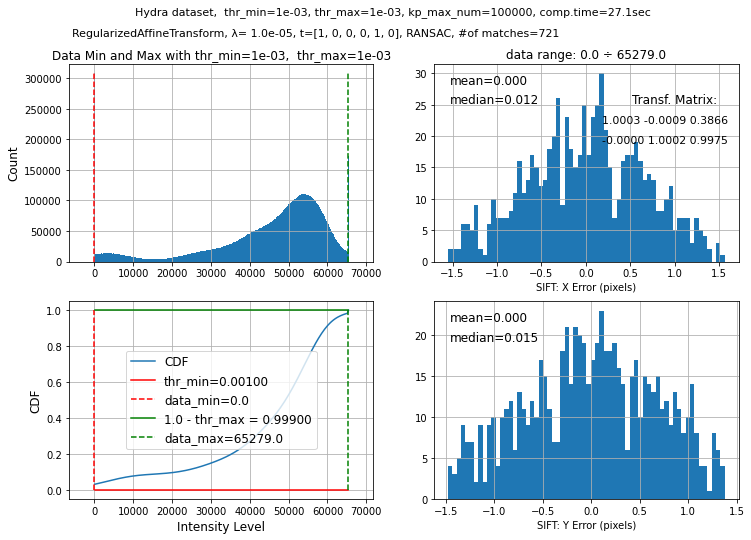

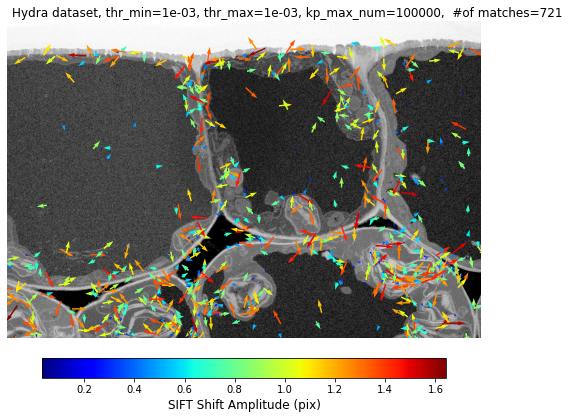

In [7]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation()

# This is where the data processing begins. Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 2: Evaluate parameters of FIBSEM data set (Data Min/Max, Working Distance, Milling Y Voltage, FOV center positions)

DASK client exists. Will perform distributed computations
Use http://localhost:8787/status to monitor DASK progress
Evaluating the parameters of FIBSEM data set (data Min/Max, Working Distance, Milling Y Voltage, FOV center positions, Scan Rate, EHT)
Using DASK distributed
Using fit_params:  SG 11 3
Saving the FIBSEM dataset statistics (Min/Max, Mill Rate, FOV Shifts into the file:  F:\Hydra\Results\FIBSEM_Data.xlsx
No milling rate data is available, isotropic voxel size is set to 8.00 nm
Using fit_params:  SG 11 3
Wall time: 12.7 s


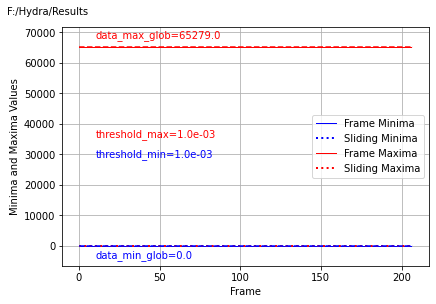

In [8]:
%%time
FIBSEM_Data = test_dataset.evaluate_FIBSEM_statistics(DASK_client = client,
                                                      fit_params = ['SG', 11, 3])
generate_report_data_minmax_xlsx(FIBSEM_Data[0])

# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

Step 3: Extract Key Points and Descriptors
DASK client exists. Will perform distributed computations
Use http://localhost:8787/status to monitor DASK progress
Using DASK distributed
Step 3: Elapsed time: 205.77 seconds

Step 4: Select Good Matches with FLANN matcher
Step 4: using RegularizedAffineTransform Transformation Model with RANSAC solver
Step 4: RegularizedAffineTransform parameters:
Step 4: Regularization matrix: 
[[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Step 4: Target Solution:  [1 0 0 0 1 0]
DASK client exists. Will perform distributed computations
Use http://localhost:8787/status to monitor DASK progress
Using DASK distributed
Mean Number of Keypoints : 721
Step 4: Elapsed time: 658.77 seconds


Calculating Cummilative Transformation Matrix:   0%|          | 0/206 [00:00<?, ?it/s]

Recalculating the shifts for preserved scales:   0%|          | 0/206 [00:00<?, ?it/s]

Wall time: 14min 29s


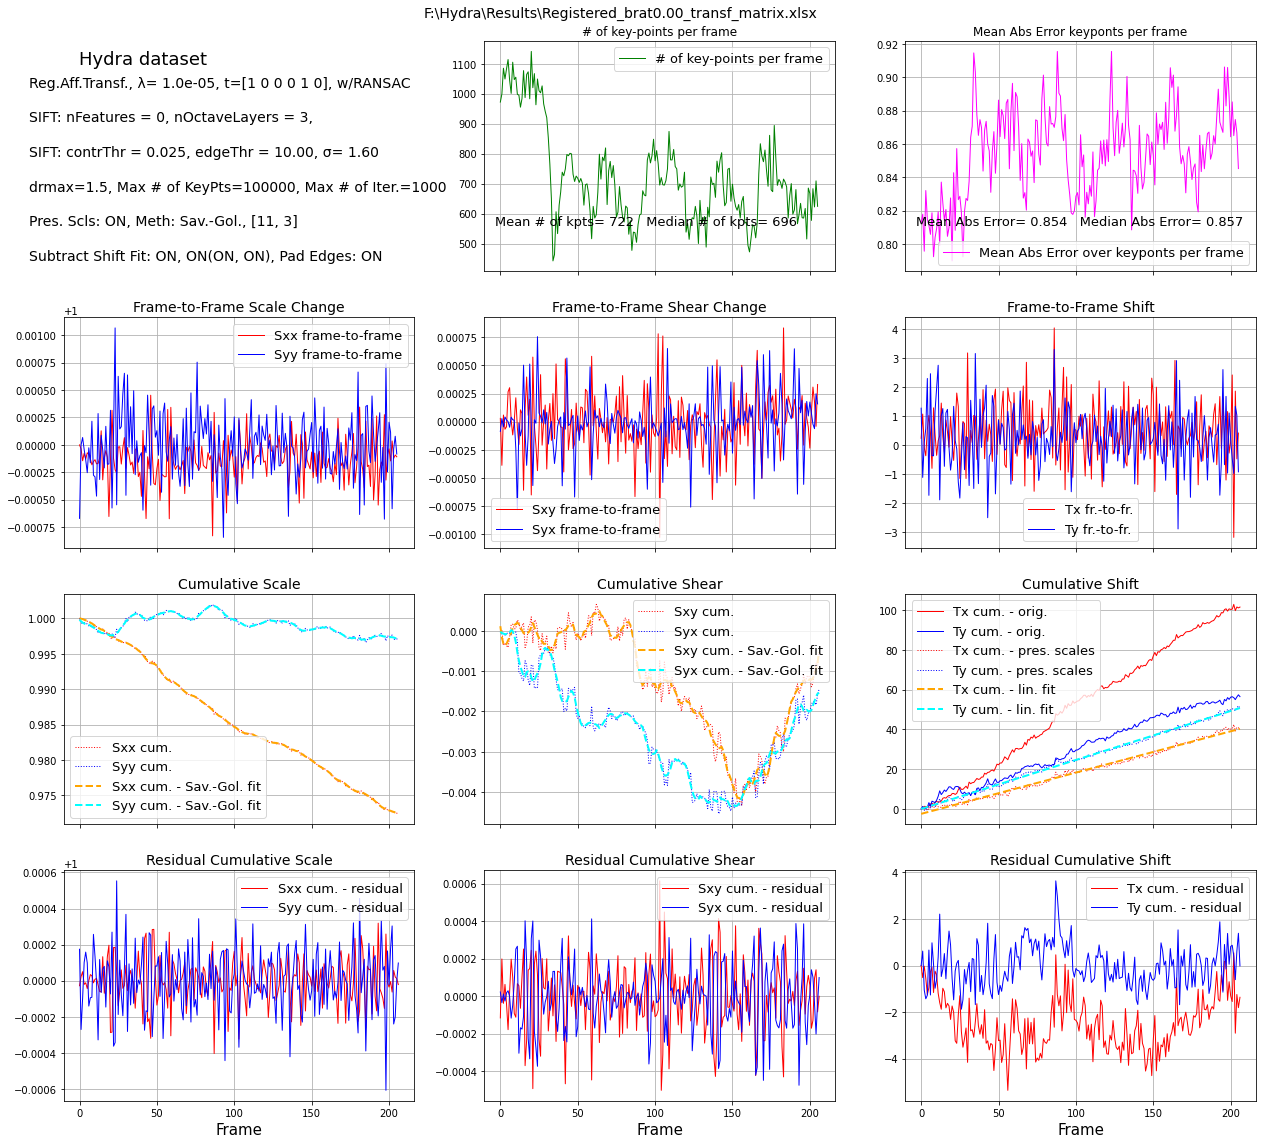

In [9]:
%%time
# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
print('Step 3: Extract Key Points and Descriptors')
fnms = test_dataset.extract_keypoints(DASK_client = client)   
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))
print('')

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if test_dataset.TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(DASK_client = client)
t3 = time.time()
print('Step 4: Elapsed time: {:.2f} seconds'.format(t3 - t2))

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

In [10]:
# here is an example of how the previous step can be modified easily without having to re-do all previous steps
# this will calculate the cumulative transformation matrix WITHOT modifying the object property subtract_linear_fit
# so this change will NOT propagate.
# tr_matr_cum_residual = test_dataset.process_transformation_matrix(subtract_linear_fit = [False, True])

# if you want to make permanet change, then you should do this:
# test_dataset.subtract_linear_fit = [False, True]
# tr_matr_cum_residual = test_dataset.process_transformation_matrix()


# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [11]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
tr_matr_cum_residual = test_dataset.check_for_nomatch_frames(thr_npt, **SIFT_kwargs)

Frames with no matches to the next frame:   []
Frames to remove:   []
No frames selected for removal


# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [12]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))

if recall_the_data:
    test_dataset = FIBSEM_dataset(fls, recall_parameters=True, dump_filename=dump_filename, disp_res=True, **SIFT_kwargs)
else:
    saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
    print('Parameters saved into the file: ', saved_dump_file)

Parameters saved into the file:  F:\Hydra\Results\Registered_brat0.00_params.bin


In [13]:
remove_key_points_data = False   # if True, the binary files with intermediate keypoints data for each frame will be removed

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass

# Define Evaluation Box

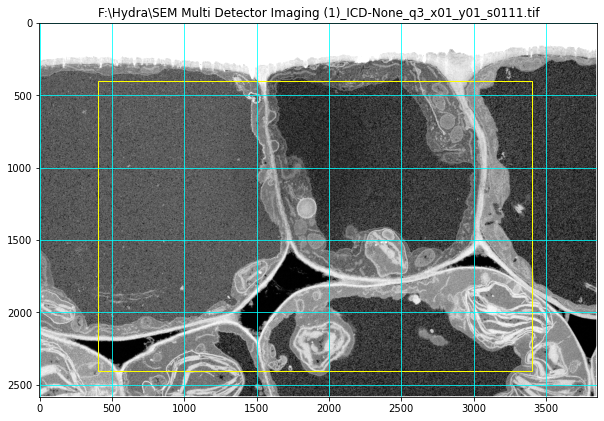

In [17]:
#evaluation_box = [250, 2000, 1450, 2650]      # optional evaluation box for defining the area over which the registration quality
#test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False)
#
# default frames are three frames: 10% from the start, 50% from the start, and 90% from the start
# alternatively you can set any list of frame indecis by using keyword frame_indices
# for example:0
# test_dataset.show_eval_box(frame_indices=[1, 100, 850], evaluation_box = evaluation_box, invert_data=False)
#
fr_ind = 100
evaluation_box = [400, 2000, 400, 3000]
xx = test_dataset.show_eval_box(invert_data=False, frame_inds=[fr_ind], evaluation_box=evaluation_box, fill_value=-10.00)

# Step 7: Transform and Save the FIB-SEM data

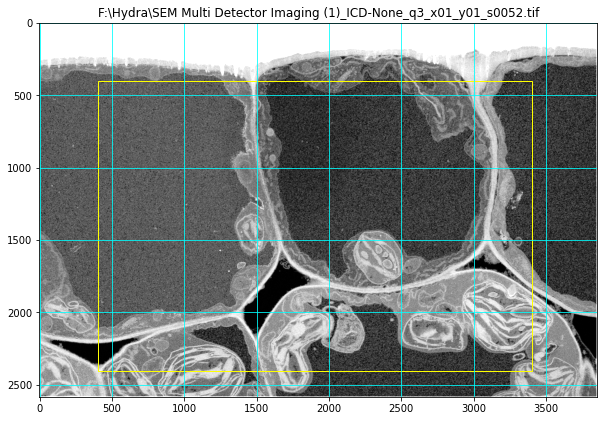

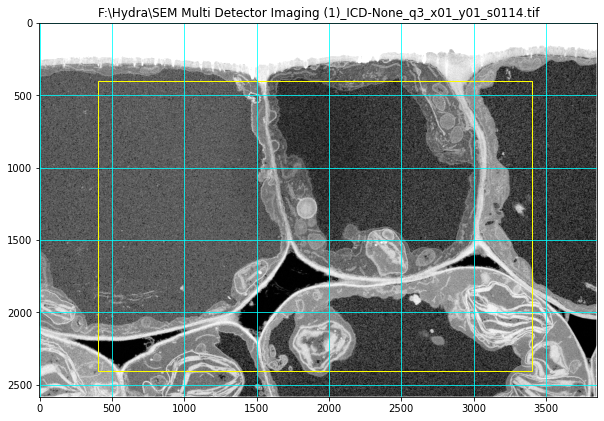

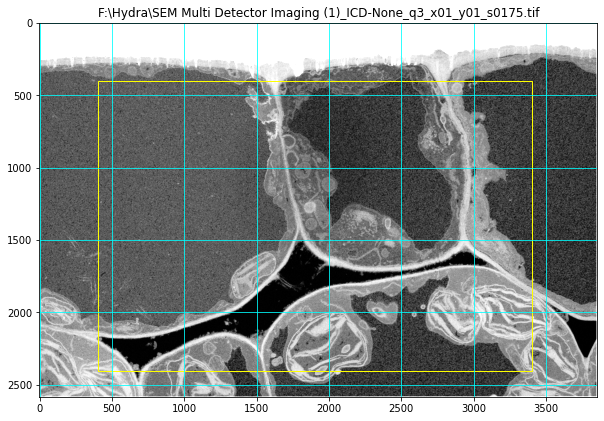

In [18]:
evaluation_box = [400, 2000, 400, 3000]
test_dataset.show_eval_box(invert_data=False,
                           frame_inds = [nfrs//5, nfrs//2, nfrs//5*4],
                           evaluation_box=evaluation_box)

In [ ]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

test_dataset.fnm_reg = 'Hydra_RegAffine_l2_1e-05_brat0.00.mrc'

evaluation_box = [400, 2000, 400, 3000]

reg_summary_RegAffine_ImB0p00, reg_summary_RegAffine_ImB0p00_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                        save_transformed_dataset = True,
                                                        save_registration_summary = True,
                                                        flatten_image = False,
                                                        ImgB_fraction=0.00,
                                                        add_offset = True,
                                                        zbin_factor = 1,
                                                        evaluation_box = evaluation_box,
                                                        sliding_evaluation_box = False,
                                                        dtp = uint16,
                                                        fnm_types = ['mrc'])

generate_report_from_xls_registration_summary(reg_summary_RegAffine_ImB0p00_xlsx)

Step 7: Transform and Save the FIB-SEM data
DASK client exists. Will perform distributed computations
Use http://localhost:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames
Transform and Save Chunks of Frames: Starting DASK jobs
Finished DASK jobs
Analyzing Registration Quality
Analyzing Frame Registration: Starting DASK jobs
Finished DASK jobs
Saving the Registration Quality Statistics into the file:  F:\Hydra\Results\Hydra_RegAffine_l2_1e-05_brat0.00_RegistrationQuality.xlsx
Creating Dask Array Stack
The resulting stack shape will be  nx=3856, ny=2584, nz=207,  data type: <class 'numpy.uint16'>
Voxel Size (nm): 8.000000 x 8.000000 x 8.000000
Saving dataset into MRC file:  F:\Hydra\Results\Hydra_RegAffine_l2_1e-05_brat0.00.mrc


Saving Frames into MRC File:   0%|          | 0/207 [00:00<?, ?it/s]

In [39]:
def save_data_stack(FIBSEMstack, **kwargs):
    '''
    Saves the dataset into a file.
    
    Parameters
        FIBSEMstack : 3D array (may be DASK array)
            Data set to be saved
        
    kwargs
    ---------
        data_dir : str
            data directory for saving the data
        fnm_reg : str
            filename for the final registed dataset
        fnm_types : list of strings
            File type(s) for output data. Options are: ['h5', 'mrc'].
            Defauls is 'mrc'. 'h5' is BigDataViewer HDF5 format, uses npy2bdv package. Use empty list if do not want to save the data.
        voxel_size : rec array of 3 elemets
            voxel size in nm
        dtp  : dtype
            Python data type for saving. Deafult is int16, the other option currently is uint8.
        disp_res : bolean
            Display messages and intermediate results
        
    Returns:
        fnms_saved : list of strings
            Paths to the files where the data set was saved.
    
    '''
    data_dir = kwargs.get("data_dir", '')
    fnm_reg = kwargs.get("fnm_reg", 'Registered_set.mrc')
    fpath_reg = os.path.join(data_dir, fnm_reg)
    fnm_types = kwargs.get("fnm_types", ['mrc'])
    voxel_size_default = np.rec.array((8.0, 8.0, 8.0), dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])
    voxel_size = kwargs.get("voxel_size", voxel_size_default)
    dtp = kwargs.get("dtp", int16)
    disp_res  = kwargs.get("disp_res", False )
    nz, ny, nx = FIBSEMstack.shape
    if disp_res:
        print('The resulting stack shape will be  nx={:d}, ny={:d}, nz={:d},  data type:'.format(nx, ny, nz), dtp)
        print('Voxel Size (nm): {:2f} x {:2f} x {:2f}'.format(voxel_size.x, voxel_size.y, voxel_size.z))

    fnms_saved = []
    if len(fnm_types)>0:
        for fnm_type in fnm_types:
            # save dataset at HDF5 file
            if fnm_type == 'h5':
                fpath_reg_h5 = fpath_reg.replace('.mrc', '.h5')
                try:
                    os.remove(fpath_reg_h5)
                except:
                    pass
                fnms_saved.append(fpath_reg_h5)
                if disp_res:
                    print('Saving dataset into Big Data Viewer HDF5 file: ', fpath_reg_h5)
                bdv_writer = npy2bdv.BdvWriter(fpath_reg_h5, nchannels=1, blockdim=((1, 256, 256),))
                bdv_writer.append_view(stack=FIBSEMstack,
                       virtual_stack_dim=(nz,ny,nx),
                       time=0, channel=0, 
                       voxel_size_xyz=(voxel_size.x, voxel_size.y, voxel_size.z),
                       voxel_units='nm')
                bdv_writer.write_xml()
                bdv_writer.close()
            if fnm_type == 'mrc':
                if disp_res:
                    print('Saving dataset into MRC file: ', fpath_reg)
                fnms_saved.append(fpath_reg)
                '''
                mode 0 -> uint8
                mode 1 -> int16
                mode 6 -> uint16
                '''
                mrc_mode = 0
                if dtp==int16:
                    mrc_mode = 1
                if dtp==uint16:
                    mrc_mode = 6
                print('Using MRC mode = ', mrc_mode)
                # Make a new, empty memory-mapped MRC file
                mrc = mrcfile.new_mmap(fpath_reg, shape=(nz, ny, nx), mrc_mode=mrc_mode, overwrite=True)
                voxel_size_angstr = voxel_size.copy()
                voxel_size_angstr.x = voxel_size_angstr.x * 10.0
                voxel_size_angstr.y = voxel_size_angstr.y * 10.0
                voxel_size_angstr.z = voxel_size_angstr.z * 10.0
                #mrc.header.cella = voxel_size_angstr
                mrc.voxel_size = voxel_size_angstr
                for j, FIBSEMframe in enumerate(tqdm(FIBSEMstack, desc = 'Saving Frames into MRC File: ', display = disp_res)):
                    mrc.data[j,:,:] = FIBSEMframe.astype(dtp)
                mrc.close()
    else:
        print('Registered data set is NOT saved into a file')
    return fnms_saved

In [37]:
mrc_stack = 'F:/Hydra/Results/Hydra_RegAffine_l2_1e-05_brat0.00.mrc'

mrc_mode=0  , dt_mrc= <class 'numpy.uint8'>


array([  0.        , 254.00390625])

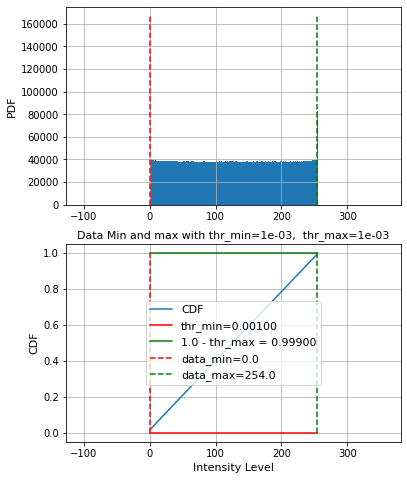

In [38]:
mrc_obj = mrcfile.mmap(mrc_stack, mode='r')
header = mrc_obj.header
mrc_mode = header.mode
if mrc_mode==0:
    dt_mrc=uint8
if mrc_mode==1:
    dt_mrc=int16
if mrc_mode==2:
    dt_mrc=float32
if mrc_mode==4:
    dt_mrc=complex64
if mrc_mode==6:
    dt_mrc=uint16
print('mrc_mode={:d} '.format(mrc_mode), ', dt_mrc=', dt_mrc)
nx, ny, nz = int32(header['nx']), int32(header['ny']), int32(header['nz'])
frame = mrc_obj.data[100, :, :].astype(dt_mrc).astype(float)
mrc_obj.close()

get_min_max_thresholds(frame, disp_res=True)

EM cross-sections dimensions (um): [30.848 20.672  1.656]
Center coordinates (um): [15.424 10.336  0.828]


Loading EM Cross-sections Data:   0%|          | 0/3 [00:00<?, ?it/s]

X-Y cross-section loaded, dimensions (pixels): 3856 2584
X-Z cross-section loaded, dimensions (pixels): 3856 207
Y-Z cross-section loaded, dimensions (pixels): 2584 207


Determining EM data range:   0%|          | 0/3 [00:00<?, ?it/s]

Will use EM-data range: 0.0 - 65000.0
Generating Cross-Section Images
Generating X-Y cross-section
Generating Y-Z cross-section
Generating X-Z cross-section
Saving image into:  F:\Hydra\Results\Hydra_RegAffine_l2_1e-05_brat0.00_crosssections.png
Wall time: 2.81 s


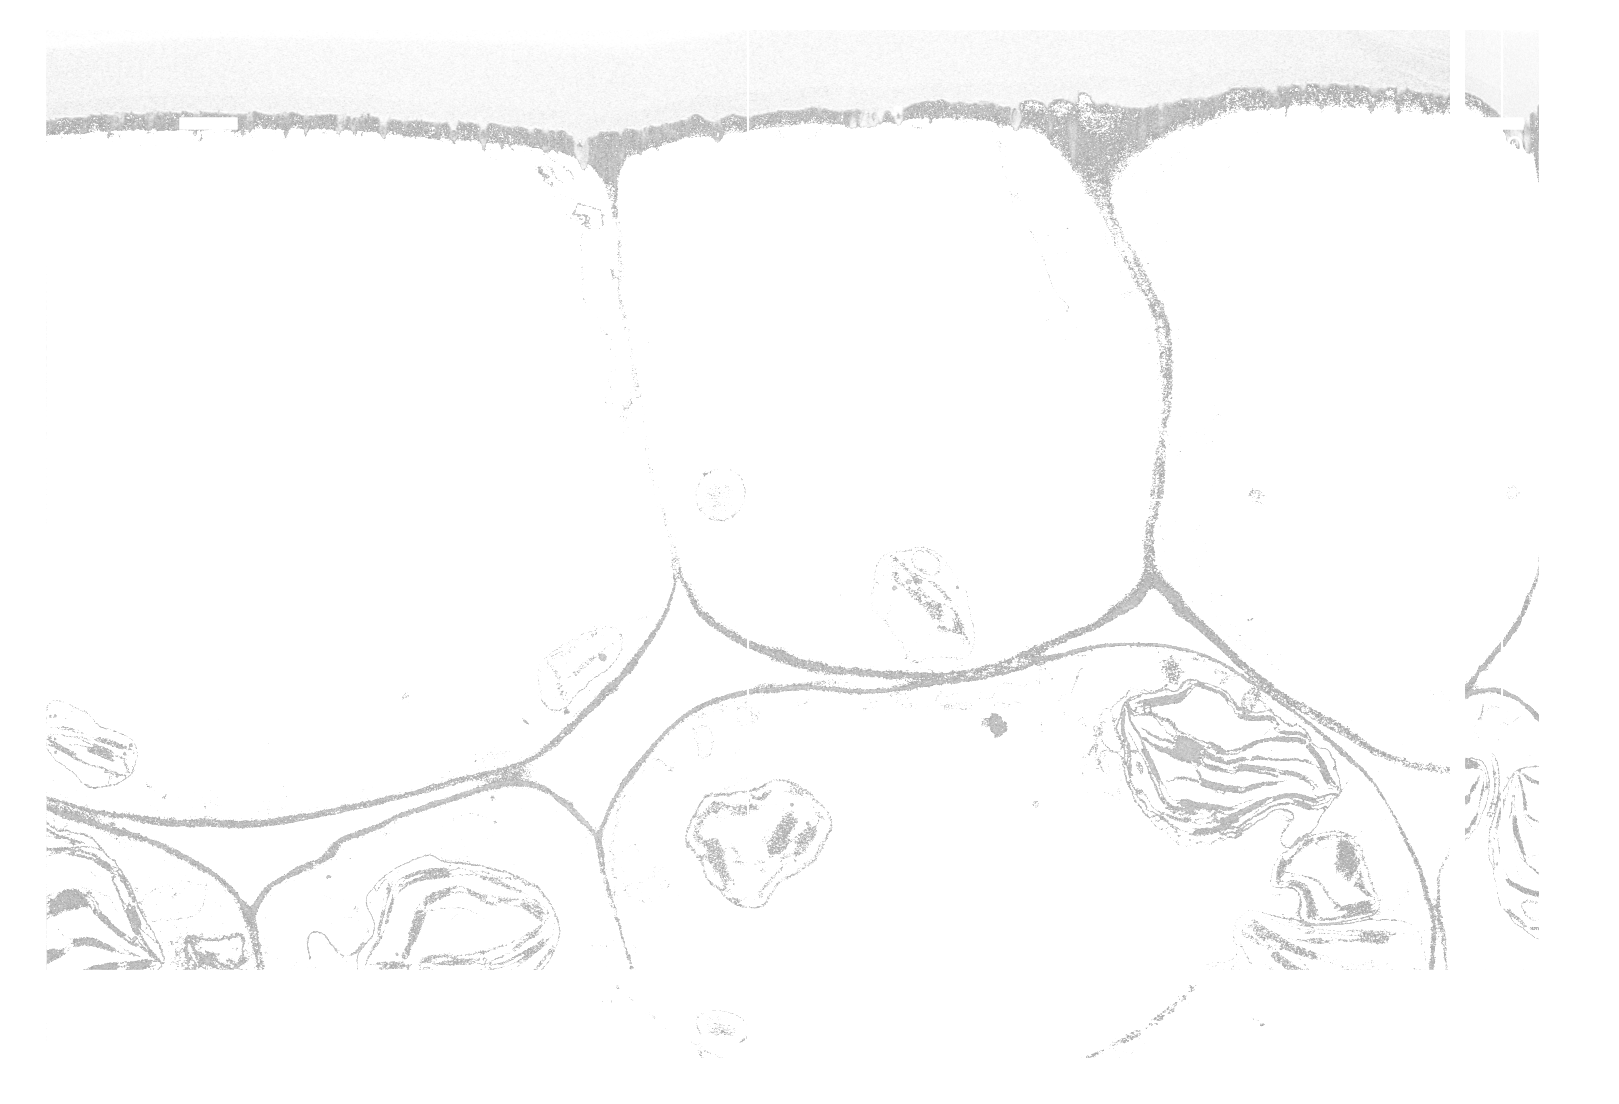

In [29]:
%%time
mrc_stack = 'F:/Hydra/Results/Hydra_RegAffine_l2_1e-05_brat0.00.mrc'
images, axs = plot_cross_sections_mrc_stack(mrc_stack,
                                            bar_length_um = 1,
                                            bar_width = 3,
                                            EM_min = 0,
                                            EM_max = 65000,
                                            #loc = (0.07, 0.80),
                                            #xsection_offsets = [0.0, 1.0, 0.0],
                                            label_font_size=8,
                                            label_offset=50,
                                            dpi=300)

Step 7: Transform and Save the FIB-SEM data
DASK client exists. Will perform distributed computations
Use http://localhost:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames
Transform and Save Chunks of Frames: Starting DASK jobs
Finished DASK jobs
Analyzing Registration Quality
Analyzing Frame Registration: Starting DASK jobs
Finished DASK jobs
Saving the Registration Quality Statistics into the file:  F:\Hydra\Results\Hydra_raw_RegistrationQuality.xlsx
Registered data set is NOT saved into a file


Removing Intermediate Registered Frame Files:   0%|          | 0/207 [00:00<?, ?it/s]

Wall time: 57.4 s


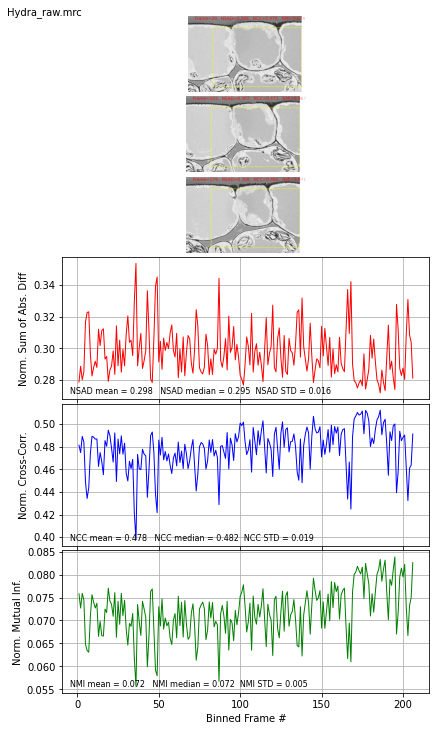

In [20]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

test_dataset.fnm_reg = 'Hydra_raw.mrc'

evaluation_box = [400, 2000, 4000, 3000]

reg_summary_raw, reg_summary_RegAffine_raw_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                        save_transformed_dataset = False,
                                                        save_registration_summary = True,
                                                        perform_transformation=False,
                                                        flatten_image = False,
                                                        ImgB_fraction=0.00,
                                                        add_offset = True,
                                                        zbin_factor = 1,
                                                        evaluation_box = evaluation_box,
                                                        sliding_evaluation_box = False,
                                                        fnm_types = ['mrc'])

generate_report_from_xls_registration_summary(reg_summary_RegAffine_raw_xlsx)

generating the registration quality summary plots:   0%|          | 0/2 [00:00<?, ?it/s]

saving the data into xlsx file:   0%|          | 0/2 [00:00<?, ?it/s]

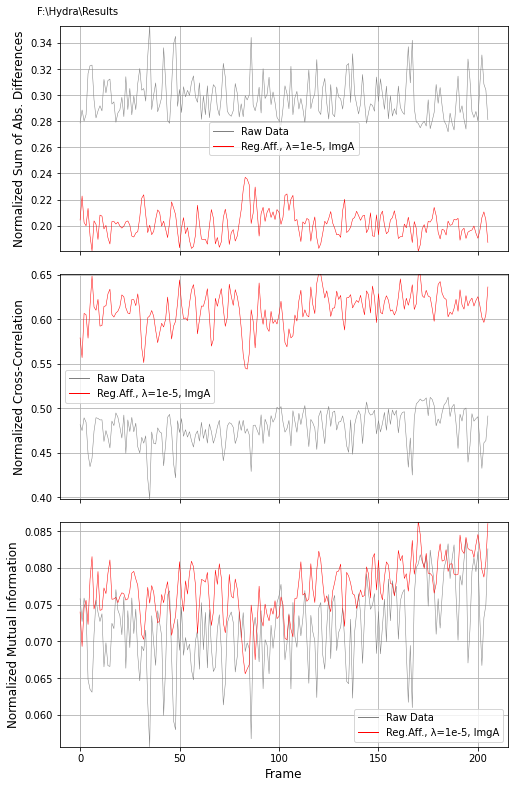

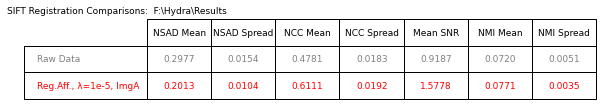

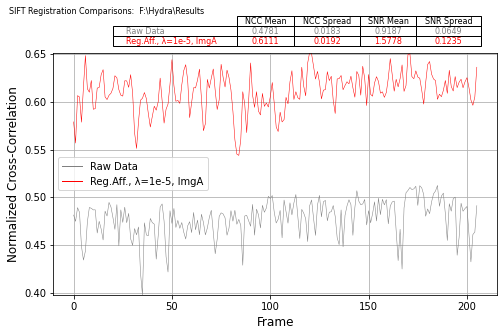

In [28]:
reg_qual_fls = [reg_summary_RegAffine_raw_xlsx,
                reg_summary_RegAffine_ImB0p00_xlsx]
pfs = ['Raw Data',
       'Reg.Aff., λ=1e-5, ImgA']

colors = ['grey', 'red']
linewidths = [0.5, 0.5, 0.4, 0.3, 0.2]

save_filename = os.path.join(data_dir, 'Regstration_Summary_Hydra1.png')
plot_registrtion_quality_xlsx(reg_qual_fls, pfs, save_filename=save_filename,
                              linewidths = linewidths,
                              colors = colors)
                              #ncc_bounds = [0.75, 1.0])
                              #nsad_bounds=[0.00, 0.15],
                              #nmi_bounds=[0.05, 0.20])

# add a plot of FiJi on top to make it more visible.
overplot = False
if overplot:
    ax = plt.gca()
    for j, fl in enumerate(reg_qual_fls[0:2]):
        rdata = data = pd.read_excel(fl, sheet_name='Registration Quality Statistics')
        image_ncc = np.array(rdata['Image NCC'])
        ax.plot(image_ncc, color=colors[j], linewidth=linewidths[j])
    fig = plt.gcf()
    fig.savefig(os.path.join(data_dir, 'Regstration_Summary_Hydra_fig_and_table.png'), dpi=300)